In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch as tc
import torchvision as tcv
from skimage import io
import random
import tqdm

from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Dane/

paths_to_imgs = [os.getcwd()+"/"+element for element in os.listdir(os.getcwd())] #path to the data folders with images
lung_opacity_path = [paths_to_imgs[0]+"/"+photo_path for photo_path in os.listdir(paths_to_imgs[0])]
normal_path = [paths_to_imgs[1]+"/"+photo_path for photo_path in os.listdir(paths_to_imgs[1])]
covid_path = [paths_to_imgs[2]+"/"+photo_path for photo_path in os.listdir(paths_to_imgs[2])]
imgs_list = lung_opacity_path + normal_path + covid_path # final list iwth all paths
random.shuffle(imgs_list) # shuffle list with randomly

In [ ]:
imgs_training_paths = imgs_list[:18000]
imgs_test_paths_2025 = imgs_list[18000:20025]

print(f"Number of training and cross-validation imgs: {len(imgs_training_paths)}")
print(f"Number of test imgs: {len(imgs_test_paths_2025)}")

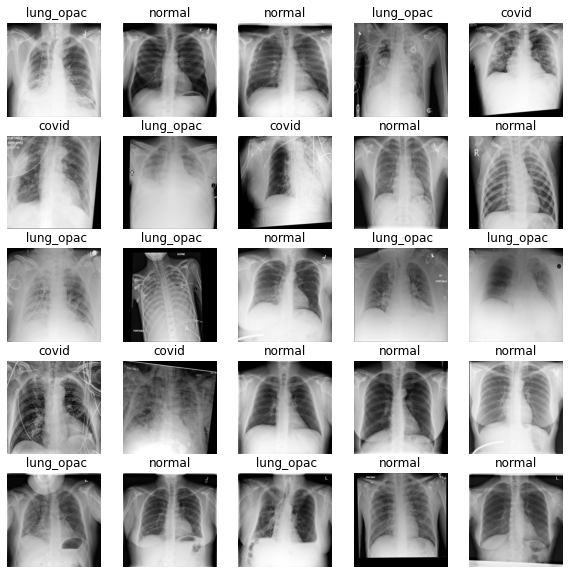

In [ ]:
# function to encode label of image based on its path
def encode_class(filename):
    if filename[78] == "C":
        label = 2
    elif filename[78] == "L":
        label = 1
    else:
        label = 0
    return label

# normal 0, lung_opacity 1, covid 2
classes = ['normal', ' lung_opac', 'covid']
# show example set of data (first 25 after suffle)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(io.imread(imgs_list[i]), cmap='gray')
    plt.axis('off')
    plt.title(classes[encode_class(imgs_list[i])])
plt.show()


In [ ]:
# define my Dataset class for loading and operating througout my data
class LungsRtgDataset(tc.utils.data.Dataset):
  def __init__(self, image_paths, transforms):
    self.image_paths = image_paths
    self.labels = [encode_class(el) for el in image_paths]
    self.transforms = transforms

  def __getitem__(self,i):
    image = plt.imread(self.image_paths[i])
    label = self.labels[i]
    image = self.transforms(image)
    return image, label

  def __len__(self):
    return len(self.image_paths)

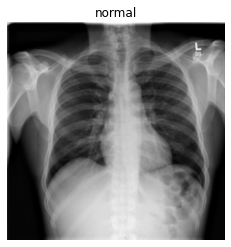

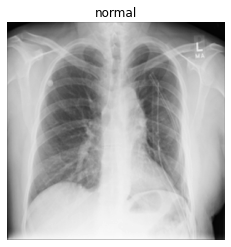

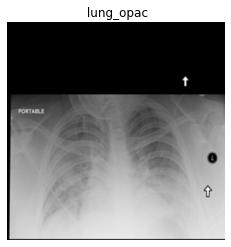

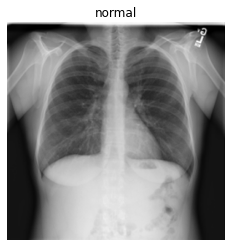

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import  transforms, datasets, models

# define transforms - toTensor, Normalize and make tree channels
# instead of one
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize([0.5], [0.5]), 
                            transforms.Lambda(lambda x: x.repeat(3, 1, 1) )])


# define all files DataLoader (it's reduntand and not used furthermore)
all_dataset = LungsRtgDataset(imgs_list, transforms=trans)
all_loader = DataLoader(all_dataset, batch_size=4, shuffle=True)

# show images with labels from one batch from all_loader
for image, label in all_loader:
    for i in range(4):
        plt.figure(figsize=(4,4))
        plt.imshow(image[i, :, :, :].permute(1, 2, 0).numpy()[...,0], cmap='gray')
        plt.axis('off')
        plt.title(classes[label[i]])
        plt.show()
    break

In [ ]:
from sklearn.model_selection import train_test_split

labels = [encode_class(el) for el in imgs_list]
print(f"Percent of training data {round(100*len(imgs_training_paths)/20025)}%.")
print(f"Percent of test data {round(100*len(imgs_test_paths_2025)/20025)}%.")

In [ ]:
# Preparing sets for validation and test
training_loaders = []
validation_loaders = []

for i in range(9):
  val_subset = LungsRtgDataset(imgs_training_paths[1000*2*i:1000*2*(i+1)], transforms=trans)
  val_loader = DataLoader(val_subset, batch_size=16, shuffle=True)
  imgs_training_subset_paths = [img_train_path for img_train_path in imgs_training_paths if img_train_path not in imgs_training_paths[1000*2*i:1000*2*(i+1)]]
  print(f"For i = {i} length of imgs train path subset equal to: {len(imgs_training_subset_paths)}") 
  train_subset = LungsRtgDataset(imgs_training_subset_paths, transforms=trans)
  train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
  validation_loaders.append(val_loader)
  training_loaders.append(train_loader)
  print(f"For i = {i} length of imgs validation path subset equal to: {len(val_subset)}") 


test_dataset = LungsRtgDataset(imgs_test_paths_2025, transforms=trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

In [ ]:
from torchsummary import summary
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

network = EfficientNet.from_pretrained('efficientnet-b3', num_classes=3)

device = "cuda:0" # "cpu"
network = network.to(device)
print(summary(network, input_size=(3, 299, 299)))

cost_function = nn.CrossEntropyLoss()
learning_rate=1e-4
optimizer = tc.optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
''' At the end - load saved parameters from file (for eval purposes)
network = EfficientNet.from_pretrained('efficientnet-b3', num_classes=3)
state_dict_path = "Batch 8, 18k samples, with cross-validation, model after 9. epoch.pth" 
network.load_state_dict(tc.load(state_dict_path))
network.to(device)'''

In [ ]:
training_size = 16000
validation_size = 2000

loss_history = []
test_loss_history = []

acc_history = []
test_acc_history = []

current_epoch = 1
num_epochs = 9

In [ ]:
for epoch in tqdm.tqdm(range(num_epochs)):
  running_loss = 0.0
  test_running_loss = 0.0

  correct = 0.0 
  test_correct= 0.0

  network.train()
  for images, labels in training_loaders[current_epoch-1]:
    images = images.to(device)
    labels = tc.tensor(labels).to(device)
    
    optimizer.zero_grad()
    
    results = network(images)

    loss = cost_function(results, labels)
    loss.backward()

    _,pred_label = tc.max(results, dim = 1)

    labels = labels.cpu().numpy()
    pred_label = pred_label.cpu().numpy()
    
    correct += (pred_label == labels).sum()
    accuracy = 100 * correct / training_size

    optimizer.step()

    running_loss += loss.item()

  network.eval()
  for images, labels in validation_loaders[current_epoch-1]:
    images = images.to(device)
    labels = tc.tensor(labels).to(device)
    
    output = network(images)
    
    val_loss = cost_function(output, labels)
    test_running_loss += val_loss.item()

    _,pred_label = tc.max(output, dim = 1)

    labels = labels.cpu().numpy()
    pred_label = pred_label.cpu().numpy()

    test_correct += (pred_label == labels).sum()
    test_accuracy = 100 * test_correct / validation_size

  print("\nCurrent epoch loss: ", running_loss / training_size)
  print("Current epoch test loss: ", test_running_loss / validation_size)
  print("Current epoch accuracy: ", accuracy)
  print("Current epoch test accuracy: ", test_accuracy)

  loss_history.append(running_loss / training_size)
  test_loss_history.append(test_running_loss / validation_size)
  acc_history.append(accuracy)
  test_acc_history.append(test_accuracy)

  save_path = "Batch 16 (retry), 18k training samples, with cross-validation, model after " + str(int(current_epoch)) + ". epoch.pth"
  tc.save(network.state_dict(), save_path)
  current_epoch += 1

In [ ]:
print(loss_history)
print(test_loss_history)
print(acc_history)
print(test_acc_history)

[0.01580085039162077, 0.007661277172708651, 0.005471364453813294, 0.0037653264027030673, 0.002642478209842011, 0.002111636395464302, 0.0017521785232088405, 0.0014447977992813321, 0.001431814060988472]
[0.00710957091068849, 0.005369332520058378, 0.0032814929519954603, 0.0024979382719902787, 0.0014335711804706079, 0.0014756834537693066, 0.0007814124432031804, 0.0007235839989571105, 0.0004054565011556406]
[90.98125, 95.84375, 97.1, 97.85, 98.56875, 98.90625, 99.0125, 99.225, 99.2625]
[95.8, 97.05, 98.2, 98.65, 99.3, 99.15, 99.45, 99.55, 99.75]


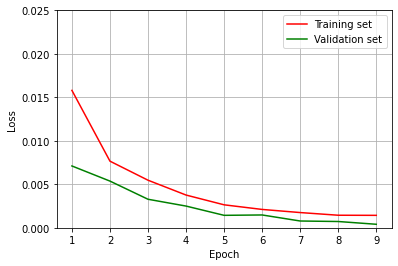

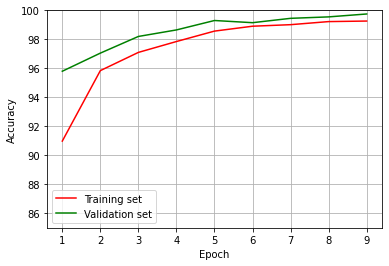

In [ ]:
x_axes = [x for x in range(1,10)]

plt.figure()
plt.plot(x_axes, loss_history, "r-")
plt.plot(x_axes, test_loss_history, "g-")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0,0.025])
plt.legend(["Training set", "Validation set"])
plt.show()

plt.figure()
plt.plot(x_axes, acc_history, "r-")
plt.plot(x_axes, test_acc_history, "g-")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([85,100])
plt.legend(["Training set", "Validation set"])
plt.show()

Predicted:  normal  lung_opac covid  lung_opac


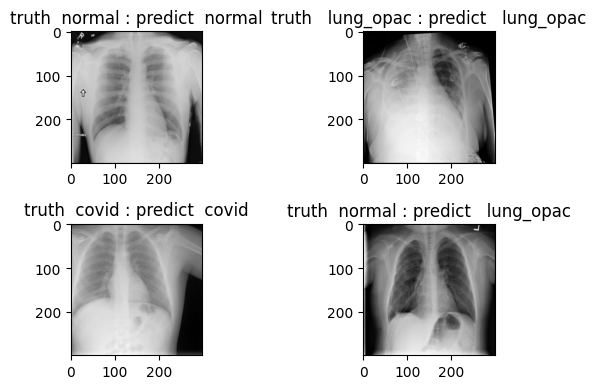

In [ ]:
# make an iterator from test_loader
# get a batch of images
test_iterator = iter(test_loader)
images, labels = test_iterator.next()
images, labels = images.cuda(), labels.cuda()

# run images through network and get predictions
results = network(images)
_, predicted = tc.max(results, 1)

rows = 2
columns = 2

# print and show predictions for those images
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

fig2 = plt.figure(dpi=100)
for i in range(4):
   fig2.add_subplot(rows, columns, i+1)
   plt.title(f'truth  {classes[labels[i].int()]} : predict  {classes[predicted[i]]}')
   plt.tight_layout()
   img = images[i] / 2 + 0.5     # this is to unnormalize the image
   img =  img.permute(1, 2, 0)[...,0]
   img = tcv.transforms.ToPILImage()(img)
   plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

true_labels = np.arange(0)
predicted_labels = np.arange(0)

for i in range(405):
  test_iterator = iter(test_loader)
  images, labels = test_iterator.next()
  images, labels = images.cuda(), labels.cuda()

  results = network(images)
  _, predicted = tc.max(results, 1)

  labels = labels.cpu().numpy()
  predicted = predicted.cpu().numpy()
  
  true_labels = np.append(true_labels, labels)
  predicted_labels = np.append(predicted_labels,predicted)

cm=confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix : ")
print(cm)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

# errors with import plotcm on windows so: 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)

In [ ]:
accuracy = np.trace(cm) / (405*5) * 100 # 405 batches, 5 imgs in each batch
print(f"Accuracy: {accuracy}%")

Accuracy: 95.3373015873016%
